In [1]:

import os
import re
import glob
import importlib

import pandas as pd
import pylab as pl
import numpy as np
import seaborn as sns
import matplotlib.gridspec as gridspec


import utils as util
import plotting as putil
import importlib

In [2]:
putil.set_sns_style(style='dark', min_fontsize=12)

In [3]:
%matplotlib notebook

In [4]:
rootdir = '/mnt/minerva/courtship-videos'
# rootdir = '/mnt/sda/Videos'
assay='single_38mm_dyad_1x1'

sessionpaths = sorted(glob.glob(os.path.join(rootdir, assay, '*')), key=util.natsort)
len(sessionpaths)

22

In [5]:
savedir = os.path.join('/mnt/minerva/analysis/FlyTracker/visualparams-38mm')
if not os.path.exists(savedir):
    os.makedirs(savedir)

In [6]:
#sess = [i for i in sessionpaths if '20220212-1150_ctns_3do_sh' in i][0]
no_trk=[]; found_trk=[];
for sess in sessionpaths:
    found_mats = glob.glob(os.path.join(sess, 'visualparams.mat'))
    if len(found_mats)==0:
        no_trk.append(os.path.split(sess)[-1])
    else:
        found_trk.append(os.path.split(sess)[-1])
print("Found {} of {} mat files.".format(len(found_trk), len(sessionpaths)))
print("No params/feats for {} files.".format(len(no_trk)))

Found 22 of 22 mat files.
No params/feats for 0 files.


In [7]:
found_trk

['mel-1',
 'mel-2',
 'mel-3',
 'mel-4',
 'mel-5',
 'mel-6',
 'mel-7',
 'mel-8',
 'mel-9',
 'mel-10',
 'mel-11',
 'mel-12',
 'mel-13',
 'suz-2',
 'suz-3',
 'suz-4',
 'suz-5',
 'suz-6',
 'suz-7',
 'suz-8',
 'suz-9',
 'suz-10']

In [8]:
d_list = []
for acq in found_trk:
    fpath = os.path.join(rootdir, assay, acq, 'visualparams.mat')
    df_ = util.load_mat_frames_and_var(fpath)
    df_['acquisition'] = acq
    
    # get species
    species_abbr = acq.split('-')[0]
    species_strain = 'na'
    if species_abbr.startswith('mau'):
        species_strain = species_abbr[3:]
        species_abbr = species_abbr[0:3]
    elif species_abbr in ('Canton-S', 'ctns'):
        species_abbr = 'mel'
        species_strain = 'cantons'
    # get age
    #age = int(re.sub('\D', '', acq.split('_')[2]))
    
    df_['species'] = species_abbr
    #df_['strain'] = species_strain
    #df_['age'] = age
    
    d_list.append(df_)
df = pd.concat(d_list)
print(df.shape)
df.head()

(1089767, 20)


,Time Vector,Angular Position,Angular Size X,Angular Size Y,Angular Area,Angular Velocity,Diff Angular Size X,Diff Angular Size Y,Diff Angular Area,Metric Length X,Metric Length Y,Metric Distance,Metric Relative Velocity,Size-to-Speed Ratio X,Size-to-Speed Ratio Y,Target Fly Orientation,Target Fly Major Axis,Target Fly Minor Axis,acquisition,species
0,0.02,-152.401791,6.955827,2.476936,13.531736,0.000000,0.000000,0.000000,0.000000,2.811255,1.0,23.128111,0.000000,inf,inf,1.462024,2.877956,1.030532,mel-1,mel
1,0.04,158.613201,0.069878,2.548890,0.139888,3110.149921,-68.859498,0.719538,-133.918482,0.027410,1.0,22.475010,-6.531008,-0.002098,-0.002099,1.072588,0.027422,0.027422,mel-1,mel
2,0.06,-154.620602,6.751848,2.464981,13.071520,-3132.338028,66.819699,-0.839091,129.316322,2.741859,1.0,23.240318,7.653080,0.179134,0.001792,1.560083,2.775125,0.896882,mel-1,mel
3,0.08,-157.521358,6.838078,2.477334,13.304803,-29.007558,0.862307,0.123526,2.332832,2.763108,1.0,23.124400,-1.159183,-1.191834,-0.011828,1.516549,2.802946,0.990558,mel-1,mel
4,0.10,-160.690199,6.688025,2.482883,13.041994,-31.688410,-1.500534,0.055493,-2.628089,2.696294,1.0,23.072700,-0.516995,-2.607660,-0.026521,1.469297,2.735961,0.895686,mel-1,mel


In [9]:
df['species'].unique()

array(['mel', 'suz'], dtype=object)

## Load FEAT

In [10]:
f_list = []; t_list=[];
for i, sp in enumerate(found_trk):
    calib_, trk_, feat_ = util.load_flytracker_data(os.path.join(rootdir, assay, sp))
    if 'cop_ind' not in calib_.keys():
        print(sp, 'No cop')
    else:
        print(sp, calib_['cop_ind'])
    # get species
    species_abbr = sp.split('-')[0]
    species_strain = 'na'
    if species_abbr.startswith('mau'):
        species_strain = species_abbr[3:]
        species_abbr = species_abbr[0:3]
    elif species_abbr in ('Canton-S', 'ctns'):
        species_abbr = 'mel'
        species_strain = 'cantons'
    # get age
    #age = int(re.sub('\D', '', sp.split('_')[2]))

    # get sex
    if float(feat_.groupby('id')['max_wing_ang'].mean().round(1).diff().abs().dropna()) == 0: # difference is super tiny
        ix_male = trk_.groupby('id')['body_area'].mean().idxmin() # use body size
    else:
        ix_male = feat_.groupby('id')['max_wing_ang'].mean().idxmax()
    feat_.loc[feat_['id']==ix_male, 'sex'] = 'm'
    feat_.loc[feat_['id']!=ix_male, 'sex'] = 'f'
    print('--', species_abbr, feat_['sex'].unique(), 'male ID: {}'.format(feat_[feat_['sex']=='m']['id'].unique()[0]))
        
    # update
    feat_['species'] = species_abbr
    feat_['strain'] = species_strain
    #feat_['age'] = age
    feat_['acquisition'] = sp
    feat_['copulation_index'] = calib_['cop_ind']
    feat_['copulation'] = calib_['cop_ind']>0
    grab_index = calib_['cop_ind']-1 if calib_['cop_ind']>0 else feat_.iloc[-1].name
    if grab_index == 0:
        grab_index = feat_.iloc[-1].name # cop_ind=1 if NO coplation (AO)
    f_list.append(feat_[feat_['frame']<=grab_index])
    # add trk, too
    trk_['acquisition'] = sp
    t_list.append(trk_[trk_['frame']<=grab_index])
feat = pd.concat(f_list) #.reset_index(drop=True)
trk = pd.concat(t_list)
feat.head()

mel-1 22428
-- mel ['m' 'f'] male ID: 0
mel-2 29773
-- mel ['m' 'f'] male ID: 0
mel-3 33636
-- mel ['m' 'f'] male ID: 0
mel-4 1
-- mel ['m' 'f'] male ID: 0
mel-5 48193
-- mel ['m' 'f'] male ID: 0
mel-6 36656
-- mel ['m' 'f'] male ID: 0
mel-7 1
-- mel ['m' 'f'] male ID: 0
mel-8 15653
-- mel ['m' 'f'] male ID: 0
mel-9 6713
-- mel ['m' 'f'] male ID: 0
mel-10 25668
-- mel ['m' 'f'] male ID: 0
mel-11 45840
-- mel ['m' 'f'] male ID: 0
mel-12 11062
-- mel ['m' 'f'] male ID: 0
mel-13 24116
-- mel ['m' 'f'] male ID: 0
suz-2 15735
-- suz ['m' 'f'] male ID: 0
suz-3 27487
-- suz ['m' 'f'] male ID: 0
suz-4 1
-- suz ['m' 'f'] male ID: 0
suz-5 1
-- suz ['m' 'f'] male ID: 0
suz-6 1
-- suz ['m' 'f'] male ID: 0
suz-7 1
-- suz ['m' 'f'] male ID: 0
suz-8 49345
-- suz ['m' 'f'] male ID: 0
suz-9 1
-- suz ['m' 'f'] male ID: 0
suz-10 1
-- suz ['m' 'f'] male ID: 0


,vel,ang_vel,min_wing_ang,max_wing_ang,mean_wing_length,axis_ratio,fg_body_ratio,contrast,dist_to_wall,dist_to_other,...,id,fpath,frame,sec,sex,species,strain,acquisition,copulation_index,copulation
0,5.340846,42.524644,0.016297,0.037604,2.083274,2.885991,2.551433,0.218977,4.853167,23.145597,...,0,/mnt/minerva/courtship-videos/single_38mm_dyad...,0,0.0,m,mel,na,mel-1,22428,True
1,5.340846,42.529207,0.027585,0.027701,2.050054,2.213771,12.388747,0.270179,4.949136,22.835741,...,0,/mnt/minerva/courtship-videos/single_38mm_dyad...,1,0.02,m,mel,na,mel-1,22428,True
2,27.911061,32.276240,0.021170,0.039535,2.045308,2.729085,7.376462,0.241550,4.768054,23.020380,...,0,/mnt/minerva/courtship-videos/single_38mm_dyad...,2,0.04,m,mel,na,mel-1,22428,True
3,25.079552,11.845944,0.019318,0.039397,2.059260,3.016229,2.337192,0.214439,4.598824,23.133707,...,0,/mnt/minerva/courtship-videos/single_38mm_dyad...,3,0.06,m,mel,na,mel-1,22428,True
4,13.210013,1.846665,0.017942,0.029397,2.045799,2.907132,2.286340,0.213984,4.557350,23.050664,...,0,/mnt/minerva/courtship-videos/single_38mm_dyad...,4,0.08,m,mel,na,mel-1,22428,True


## Load binary behaviors from Matlab

In [11]:
basedir = '/mnt/minerva/analysis/FlyTracker'
# matlab_src = '/home/julianarhee/Documents/projects/flytracker-analysis/overviews2/Ddata.mat'
matlab_src = os.path.join(basedir, 'flytracker-matlab/overviews-38mm-mel/Ddata-38mm-mel.mat')
assert os.path.exists(matlab_src), "Cannot found matlab file"
# Set save dir
destdir = os.path.join(basedir,'single-38mm-dyad-mel', 'figures')
if not os.path.exists(destdir):
    os.makedirs(destdir)
# set FIGID
figid = 'flytracker-matlab/overviews2/Ddata.mat & visualparams.mat'
print(destdir)

/mnt/minerva/analysis/FlyTracker/single-38mm-dyad-mel/figures


In [92]:
importlib.reload(util)

<module 'utils' from '/home/julianarhee/Repositories/flytracker/utils.py'>

In [12]:
events1 = util.load_binary_evs_from_mat(matlab_src, feat=feat)
events1 = util.add_bout_durations(events1)

melanogaster mel-1


/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


melanogaster mel-10
melanogaster mel-11
melanogaster mel-12
melanogaster mel-13
melanogaster mel-2
melanogaster mel-3
melanogaster mel-4
melanogaster mel-5
melanogaster mel-6
melanogaster mel-7
melanogaster mel-8
melanogaster mel-9


In [13]:
matlab_src2 = os.path.join(basedir, 'flytracker-matlab/overviews-38mm-suz/Ddata-38mm-suz.mat')

events2 = util.load_binary_evs_from_mat(matlab_src2, feat=feat)
events2 = util.add_bout_durations(events2)

suzukii suz-10
suzukii suz-2
suzukii suz-3
suzukii suz-4
suzukii suz-5
suzukii suz-6
suzukii suz-7
suzukii suz-8
suzukii suz-9


In [14]:
events = pd.concat([events1, events2])
del events1
del events2

In [15]:
events.shape

(1089767, 40)

## Combine Visual params and Binary events

In [16]:
print([a for a, d_ in df.groupby('acquisition') if a not in events['acquisition'].unique()])
# acq = '20220525_Canton-S_age4_m_sh_f_gh_1'
# events[events['acquisition']==acq]

[]


In [17]:
curr_acqs = events['acquisition'].unique()
vparams = df[df['acquisition'].isin(curr_acqs)].copy()
vparams = vparams.rename(columns={'Time Vector': 'Time Vector (s)'})
print(vparams.shape, events.shape)

del df

(1089767, 20) (1089767, 40)


In [18]:
vparams_behav = pd.merge(vparams, events, on=['Time Vector (s)', 'acquisition', 'species'])
print(vparams_behav.shape)

(1089767, 57)


In [20]:
vparams.shape, events.shape

((1089767, 20), (1089767, 40))

In [17]:
# # acq = '20220128-1516_mauR4_4do_gh'
# acq= '20220203-1147_yak_7do_sh'
# #acq='20220301_Canton-S_age5_m_sh_f_gh_1'
# beh_ = vparams_behav[vparams_behav['acquisition']==acq].copy()
# beh_.shape

# Calculate bouts

In [21]:
import scipy.stats as spstats

In [22]:
m_list = []
for (acq, species), beh_ in vparams_behav.groupby(['acquisition', 'species']):
    if species=='rsim':
        continue
    mean_ = beh_.groupby('boutnum').mean().reset_index()
    mean_['Angular Position Circ'] = beh_.groupby('boutnum')['Angular Position'].apply(spstats.circmean, high=180, low=-180)
    beh_['Metric Relative Velocity Abs'] = beh_.groupby('boutnum')['Metric Relative Velocity'].apply(np.abs)
    mean_['Metric Relative Velocity Abs'] = beh_.groupby('boutnum')['Metric Relative Velocity Abs'].mean()
    mean_['acquisition'] = acq
    mean_['species'] = species
    m_list.append(mean_)
    
bouts = pd.concat(m_list).reset_index(drop=True)

In [23]:
# mean_[mean_['Left Wing Extensions']>0]['boutnum'].unique()

# behav = 'Right Wing Extensions'
# plotdf = mean_[mean_[behav]>0]

# plotdf[[x, y, z]]
bouts.head()

,boutnum,Time Vector (s),Angular Position,Angular Size X,Angular Size Y,Angular Area,Angular Velocity,Diff Angular Size X,Diff Angular Size Y,Diff Angular Area,...,facing_angle,leg_dist,id,copulation_index,copulation,boutdur,Angular Position Circ,Metric Relative Velocity Abs,acquisition,species
0,0.0,1.68,-30.911966,11.078975,5.119449,63.758791,11.056307,1.897395,0.890893,30.729403,...,2.340057,12.243019,0.0,22428.0,1.0,3.32,166.245988,2.635321,mel-1,mel
1,1.0,3.46,36.502366,45.704947,20.231603,728.124654,2.276624,7.530064,1.715456,165.861583,...,0.636800,0.012465,0.0,22428.0,1.0,0.20,36.501706,1.229570,mel-1,mel
2,2.0,3.59,37.198286,46.584720,18.474595,675.970593,25.527693,2.209564,-3.589359,-100.139972,...,0.661166,0.359915,0.0,22428.0,1.0,0.02,37.198286,0.749459,mel-1,mel
3,3.0,3.71,53.239607,53.193176,20.191767,844.120142,20.927075,9.173744,2.822800,258.818755,...,0.930956,0.015504,0.0,22428.0,1.0,0.18,53.240479,0.426954,mel-1,mel
4,4.0,3.82,70.371137,61.609474,23.496668,1136.955996,95.956962,50.684243,21.498931,1890.047283,...,1.257204,0.104420,0.0,22428.0,1.0,0.00,70.371137,2.487355,mel-1,mel


# Plotting

In [24]:
species_list = bouts['species'].unique()
species_colors = sns.color_palette('colorblind', n_colors=len(species_list))

In [25]:
behavs2plot = ['Orienting', 'Chasing', 'Left Wing Extensions', 'Right Wing Extensions']

In [26]:
savedir

'/mnt/minerva/analysis/FlyTracker/visualparams-38mm'

<IPython.core.display.Javascript object>


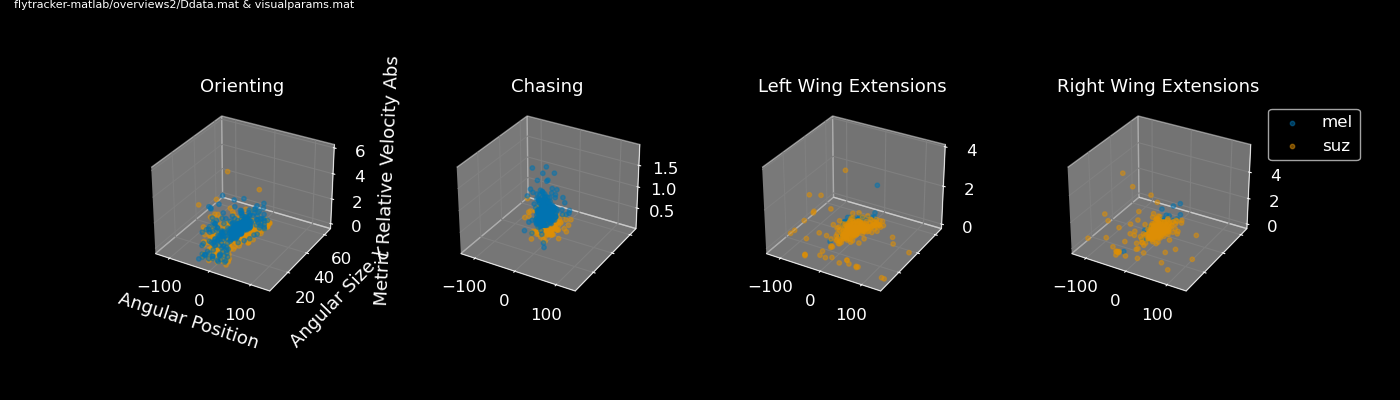

/mnt/minerva/analysis/FlyTracker/visualparams-38mm/3d-scatter_x-Angular Position_y-Angular Size X_z-Metric Relative Velocity Abs_mau-mel-yak.png


In [27]:
fig, axn= pl.subplots(1, len(behavs2plot), figsize=(14,4), subplot_kw={'projection': '3d'}, sharex=True, sharey=True)
#y = 'Metric Length X' # 'Angular Area'
#x = 'Metric Distance' #'Angular Position'
y = 'Angular Size X'
x = 'Angular Position'
z = 'Metric Relative Velocity Abs' #'Angular Velocity'

for ai, behav in enumerate(behavs2plot):
    ax=axn[ai]
    for col, sp in zip(species_colors, species_list):
        if sp=='sant':
            continue
        plotdf = bouts[(bouts['species']==sp) & (bouts[behav]>0)]
        ax.scatter(plotdf[x], plotdf[y], plotdf[z], color=col, alpha=0.5, s=10, label=sp)
    ax.set_title(behav)
    if ai == 0:
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        ax.set_zlabel(z)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
pl.subplots_adjust(wspace=0.5, left=0.1, right=0.9)

putil.label_figure(fig, figid)
figname = '3d-scatter_x-{}_y-{}_z-{}_{}'.format(x, y, z, 'mau-mel-yak')
pl.savefig(os.path.join(savedir, '{}.png'.format(figname)))
print(os.path.join(savedir, '{}.png'.format(figname)))

<IPython.core.display.Javascript object>


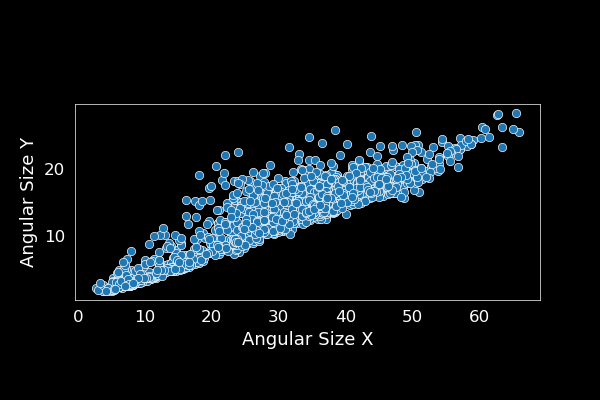

In [28]:
fig, ax = pl.subplots()
sns.scatterplot(data=bouts[bouts['Disengaged']==0], x='Angular Size X', y='Angular Size Y')
ax.set_aspect(1)

In [29]:
behavs2plot = ['Orienting', 'Chasing', 'Left Wing Extensions', 'Right Wing Extensions']

In [30]:
species_cdict = dict((k, v) for k, v in zip(species_list, species_colors))

<IPython.core.display.Javascript object>


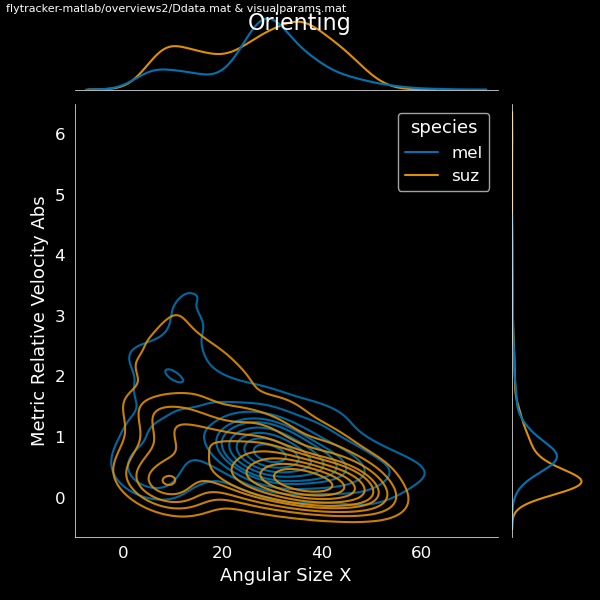

/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(


/mnt/minerva/analysis/FlyTracker/visualparams-38mm/joint-Angular Size X-Metric Relative Velocity Abs_Orienting_suz-mel.png


<IPython.core.display.Javascript object>


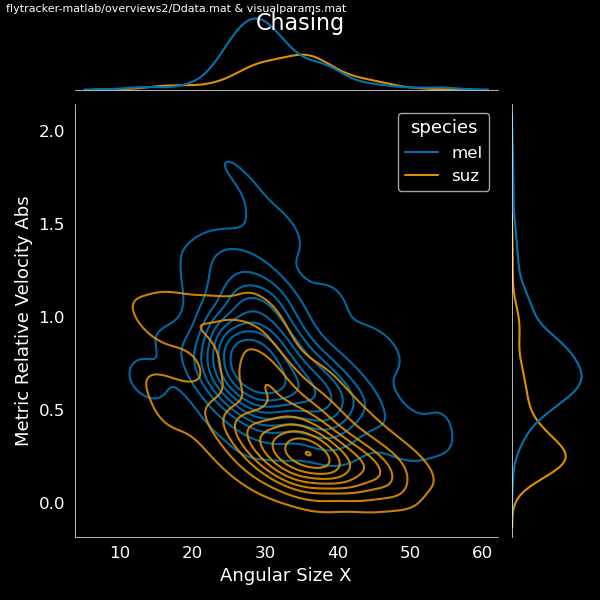

/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(


/mnt/minerva/analysis/FlyTracker/visualparams-38mm/joint-Angular Size X-Metric Relative Velocity Abs_Chasing_suz-mel.png


<IPython.core.display.Javascript object>


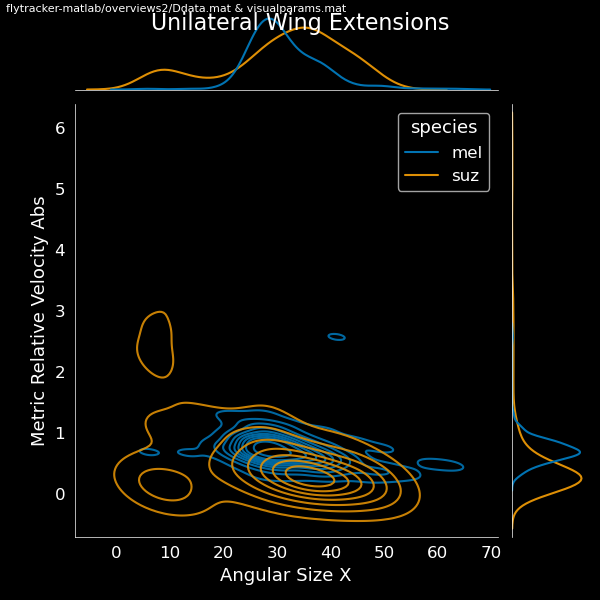

/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(


/mnt/minerva/analysis/FlyTracker/visualparams-38mm/joint-Angular Size X-Metric Relative Velocity Abs_Unilateral Wing Extensions_suz-mel.png


<IPython.core.display.Javascript object>


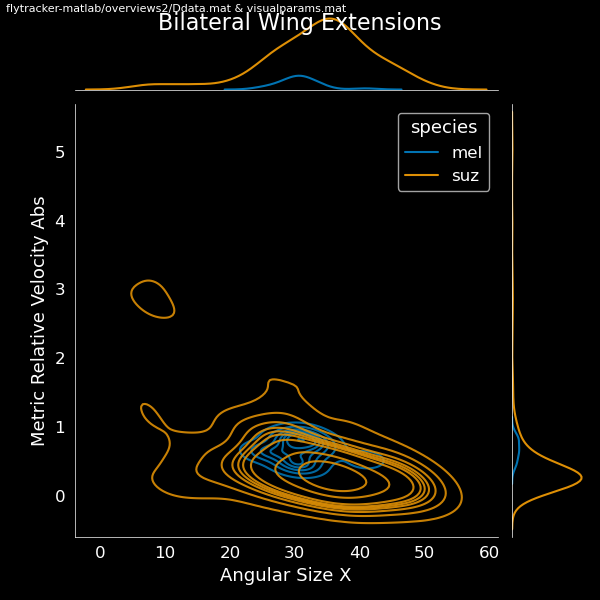

/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(


/mnt/minerva/analysis/FlyTracker/visualparams-38mm/joint-Angular Size X-Metric Relative Velocity Abs_Bilateral Wing Extensions_suz-mel.png


In [33]:
#fig, ax = pl.subplots(1, 1) #len(behavs2plot), figsize=(12,4), subplot_kw={'projection': '3d'})
#x = 'Angular Position' #'Angular Size X'
#y = 'Metric Length X' #'Angular Position' #'Metric Relative Velocity' 

behavs2plot = ['Orienting', 'Chasing', 'Unilateral Wing Extensions', 'Bilateral Wing Extensions']

x = 'Angular Size X'
y = 'Metric Relative Velocity Abs'
for behav in behavs2plot:
    plotdf = bouts[bouts[behav]>0].copy()
    for curr_species in [['suz', 'mel']]: #[['mau', 'mel', 'yak']]: #[['mau', 'mel'], ['yak', 'sant']]:
        plotdf1 = plotdf[plotdf['species'].isin(curr_species)]
        g = sns.jointplot(data=plotdf1, x=x, y=y, hue='species', palette=species_cdict,
                  kind='kde', joint_kws={'s': 10, 'alpha': 0.9})
        g.fig.suptitle(behav)

        figname = 'joint-{}-{}_{}_{}'.format(x, y, behav, '-'.join(curr_species))
        
        putil.label_figure(g.fig, figid)
        pl.savefig(os.path.join(savedir, '{}.png'.format(figname)))
        print(os.path.join(savedir, '{}.png'.format(figname)))

In [83]:
behav_colors

[(0.08605633600581403, 0.23824692404212, 0.30561236308077167),
 (0.32927729263408284, 0.4762845556584382, 0.1837155549758328),
 (0.8146245329198283, 0.49548316572322215, 0.5752525936416857),
 (0.7587183008012618, 0.7922069335474338, 0.9543861221913403)]

In [88]:
behav_colors

[(0.08523511613408935, 0.32661779003565533, 0.2973201282529313),
 (0.6328422475018423, 0.4747981096220677, 0.29070209208025455),
 (0.7779565181455343, 0.7069421942599752, 0.9314406084043191)]

In [103]:
bouts[x].max(), bouts[y].max()


(77.09965386378744, 14.193232051379242)

In [104]:
bouts[x].min(), bouts[y].min()


(4.264370865882899, 0.0035920323738461023)

<IPython.core.display.Javascript object>


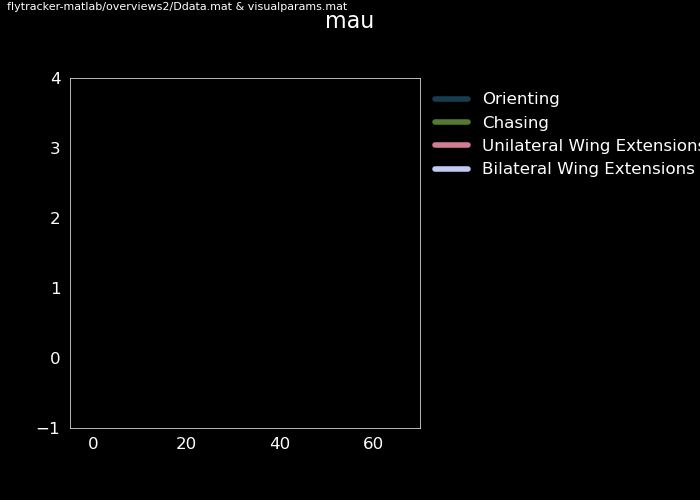

/mnt/minerva/analysis/FlyTracker/visualparams-38mm/joint-Angular Size X-Metric Relative Velocity Abs_mau.png


<IPython.core.display.Javascript object>


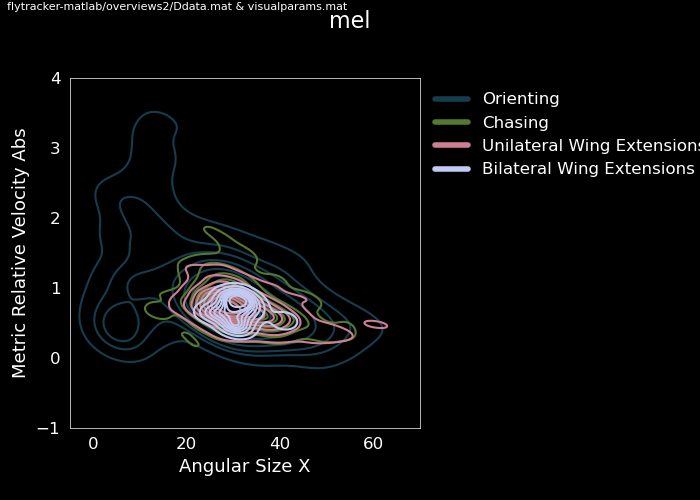

/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(
/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(
/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(
/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(


/mnt/minerva/analysis/FlyTracker/visualparams-38mm/joint-Angular Size X-Metric Relative Velocity Abs_mel.png


<IPython.core.display.Javascript object>


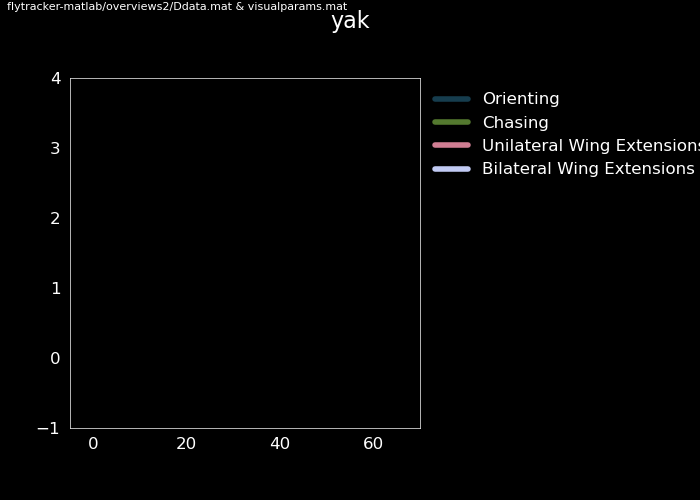

/mnt/minerva/analysis/FlyTracker/visualparams-38mm/joint-Angular Size X-Metric Relative Velocity Abs_yak.png


<IPython.core.display.Javascript object>


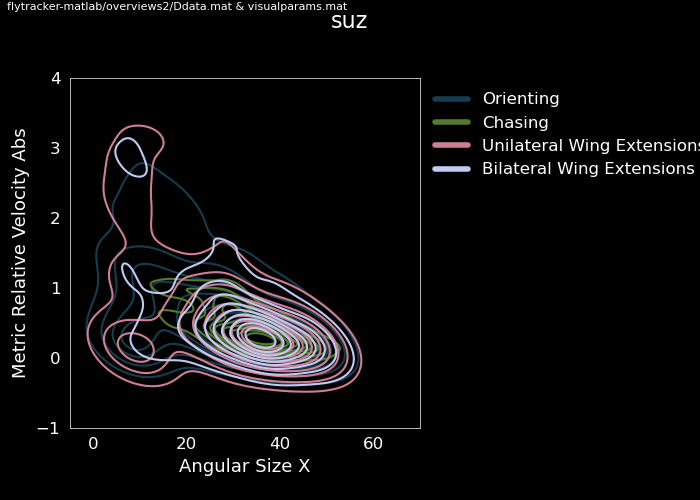

/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(
/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(
/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(
/home/julianarhee/anaconda3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(


/mnt/minerva/analysis/FlyTracker/visualparams-38mm/joint-Angular Size X-Metric Relative Velocity Abs_suz.png


In [35]:
#import SeabornFig2Grid as sfg

behavs2plot = ['Orienting', 'Chasing', 'Unilateral Wing Extensions', 'Bilateral Wing Extensions']
behav_colors = sns.color_palette('cubehelix', n_colors=len(behavs2plot))
behav_cdict = dict((k, v) for k, v in zip(behavs2plot, behav_colors))

x = 'Angular Size X'
y = 'Metric Relative Velocity Abs'

for curr_species in ['mau', 'mel', 'yak', 'suz']: #[['mau', 'mel'], ['yak', 'sant']]:
    plotdf1 = bouts[bouts['species'].isin([curr_species])]
    
    fig, ax = pl.subplots(figsize=(7,5))
    for ai, (col, behav) in enumerate(zip(behav_colors, behavs2plot)):
        plotdf = plotdf1[plotdf1[behav]>0].copy()
        sns.kdeplot(data=plotdf, x=x, y=y, color=col, ax=ax, label=behav,
                        alpha=1, lw=2, legend=1)
    ax.set_box_aspect(1)
    
    legh = putil.custom_legend(behavs2plot, behav_colors)
    ax.legend(handles=legh, loc='upper left', bbox_to_anchor=(1,1), frameon=False)
    
    ax.set_xlim([-5, 70]) #np.ceil(bouts[x].max())])
    ax.set_ylim([-1, 4]) #np.ceil(bouts[y].max())])

    
    pl.subplots_adjust(left=0.1, right=0.6)
    fig.suptitle(curr_species)
    #g.fig.suptitle(behav)
    figname = 'joint-{}-{}_{}'.format(x, y, curr_species)

    putil.label_figure(fig, figid)
    pl.savefig(os.path.join(savedir, '{}.png'.format(figname)))
    print(os.path.join(savedir, '{}.png'.format(figname)))

## Color by behavior for each species

In [232]:
non_behav_cols = [c for c in bouts.columns if c not in behavs2plot]

In [236]:
melted_bouts = pd.melt(bouts[bouts['Disengaged']==0], id_vars=non_behav_cols, value_vars=behavs2plot, var_name='behavior', value_name='fraction_of_bout')

In [255]:
bouts[bouts['boutnum']==1][[x, 'Orienting']]

,Metric Distance,Orienting
1,13.093747,0.000000
313,3.585707,0.714286
437,2.110105,0.590909
595,3.218086,1.000000
889,1.968769,0.000000
1597,11.942084,0.000000
2100,10.950500,1.000000
2437,4.085986,0.000000
2588,9.659978,1.000000
2662,11.656987,1.000000


<IPython.core.display.Javascript object>


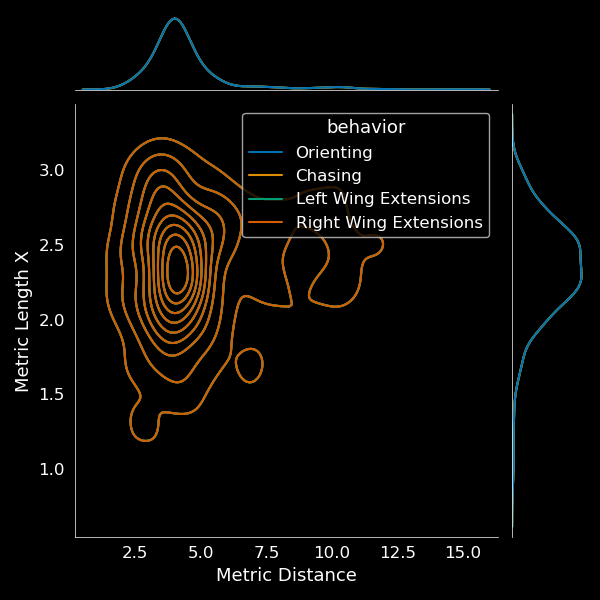

In [245]:
#fig, ax = pl.subplots()
plotdf = melted_bouts[melted_bouts['species']=='mel']
g = sns.jointplot(data=plotdf, x=x, y=y, hue='behavior', #palette='colorblind', 
                 kind='kde')

<IPython.core.display.Javascript object>


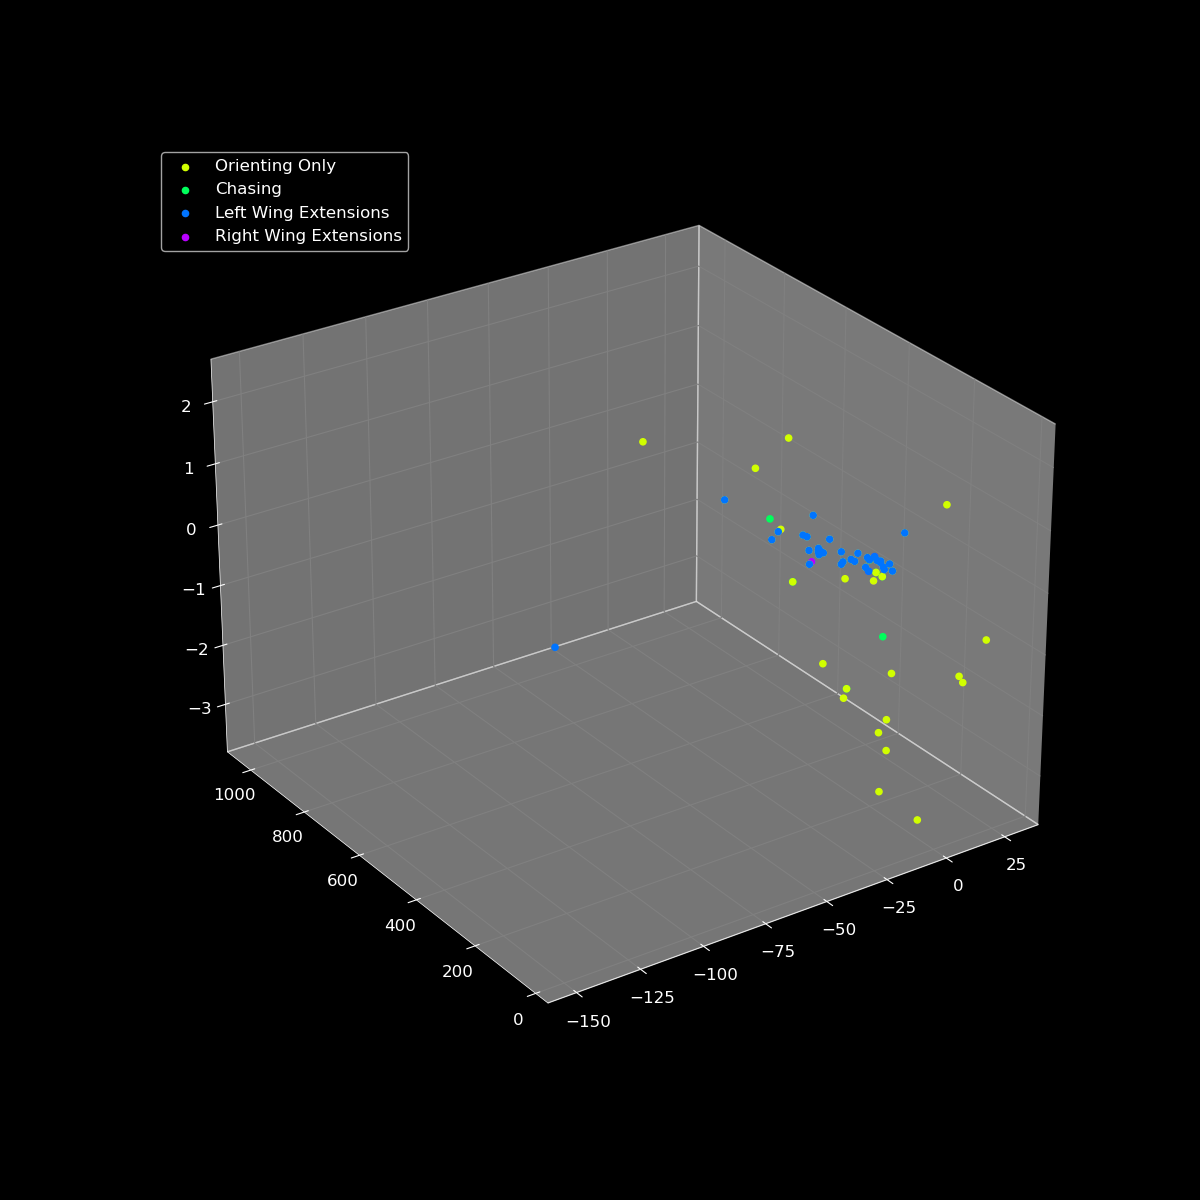

In [143]:
#fig, axn = pl.subplots(1, len(behavs2plot), figsize=(12,4), subplot_kw={'projection': '3d'})
fig, ax = pl.subplots(1, 1, figsize=(12,12), subplot_kw={'projection': '3d'})

y = 'Angular Area'
x = 'Angular Position'
z = 'Metric Relative Velocity' #'Angular Velocity'

for ai, (col, behav) in enumerate(zip(colors, behavs2plot)):
    #ax=axn[ai]
    plotdf = mean_[mean_[behav]>0]
    ax.scatter(plotdf[x], plotdf[y], plotdf[z], color=col, alpha=1, s=20, label=behav)
    # sns.scatterplot(data=plotdf, y=y, x=x, ax=ax, label=behav,
    #                 hue=z, palette='PuBuGn', size=z,  #hue_norm=(-10, 10),
    #                alpha=0.2, edgecolor='none')
    #ax.set_title(behav)
    ax.legend(bbox_to_anchor=(0, 1), loc='upper left')

In [98]:
beh_[beh_['boutnum']==11][['Orienting', 'Chasing', 'Unilateral Wing Extensions', 'Putative Tap Events','Licking/Proboscis Ext', 'Copulation Attempts', 'Disengaged']]

,Orienting,Chasing,Unilateral Wing Extensions,Putative Tap Events,Licking/Proboscis Ext,Copulation Attempts,Disengaged
673844,0.0,0.0,0,1.0,0.0,0.0,0.0
673845,0.0,0.0,0,1.0,0.0,0.0,0.0


In [114]:
beh_[beh_['boutnum']==25][['Angular Position']]

,Angular Position
678809,25.917500
678810,20.976569
678811,18.828412
678812,14.547227
678813,13.841647
...,...
678941,30.000047
678942,30.449236
678943,29.700249
678944,30.119232


In [ ]:
spstats.cir

# plot

In [83]:
behavs2plot = ['Orienting Only', 'Chasing', 'Left Wing Extensions', 'Right Wing Extensions']
colors = sns.color_palette('hsv', n_colors=len(behavs2plot))

<IPython.core.display.Javascript object>


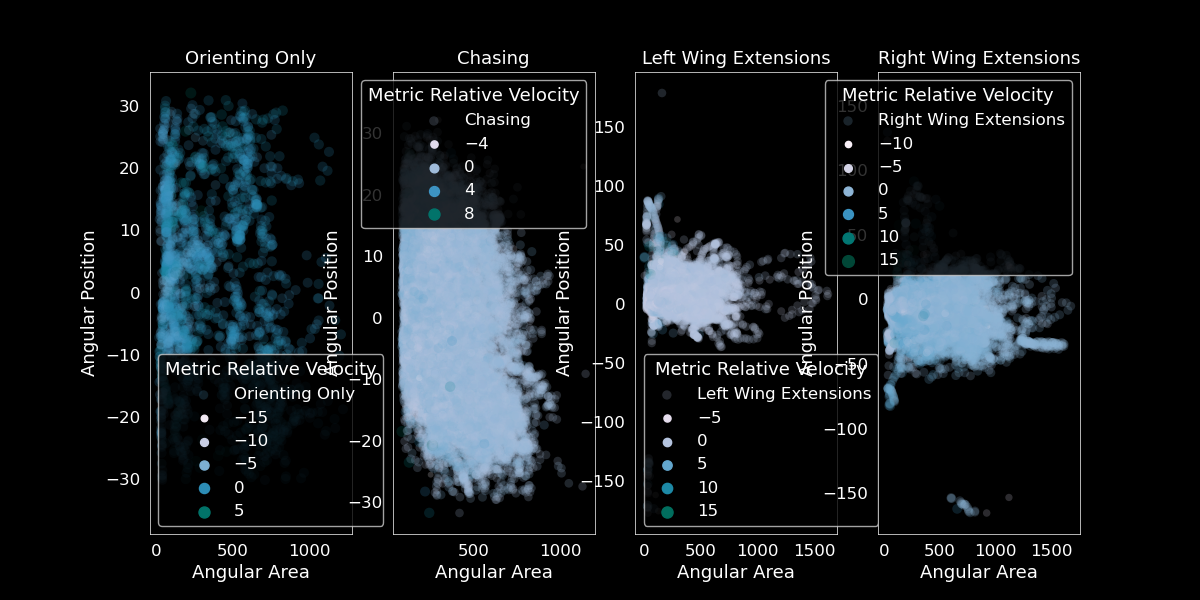

In [84]:
fig, axn = pl.subplots(1, len(behavs2plot), figsize=(12,6)) #,subplot_kw={'projection': '3d'})
x = 'Angular Area'
y = 'Angular Position'
z = 'Metric Relative Velocity' #'Angular Velocity'

for ai, (col, behav) in enumerate(zip(colors, behavs2plot)):
    ax=axn[ai]
    plotdf = beh_[beh_[behav]==1]
    #ax.scatter(plotdf[x], plotdf[y], plotdf[z], color=col)
    sns.scatterplot(data=plotdf, y=y, x=x, ax=ax, label=behav,
                    hue=z, palette='PuBuGn', size=z,  #hue_norm=(-10, 10),
                   alpha=0.2, edgecolor='none')
    ax.set_title(behav)
    #ax.legend_.remove()
    #ax.set_xlim([-50, 50])
    #ai+=1
    #ax.set_zscale("log")

<IPython.core.display.Javascript object>


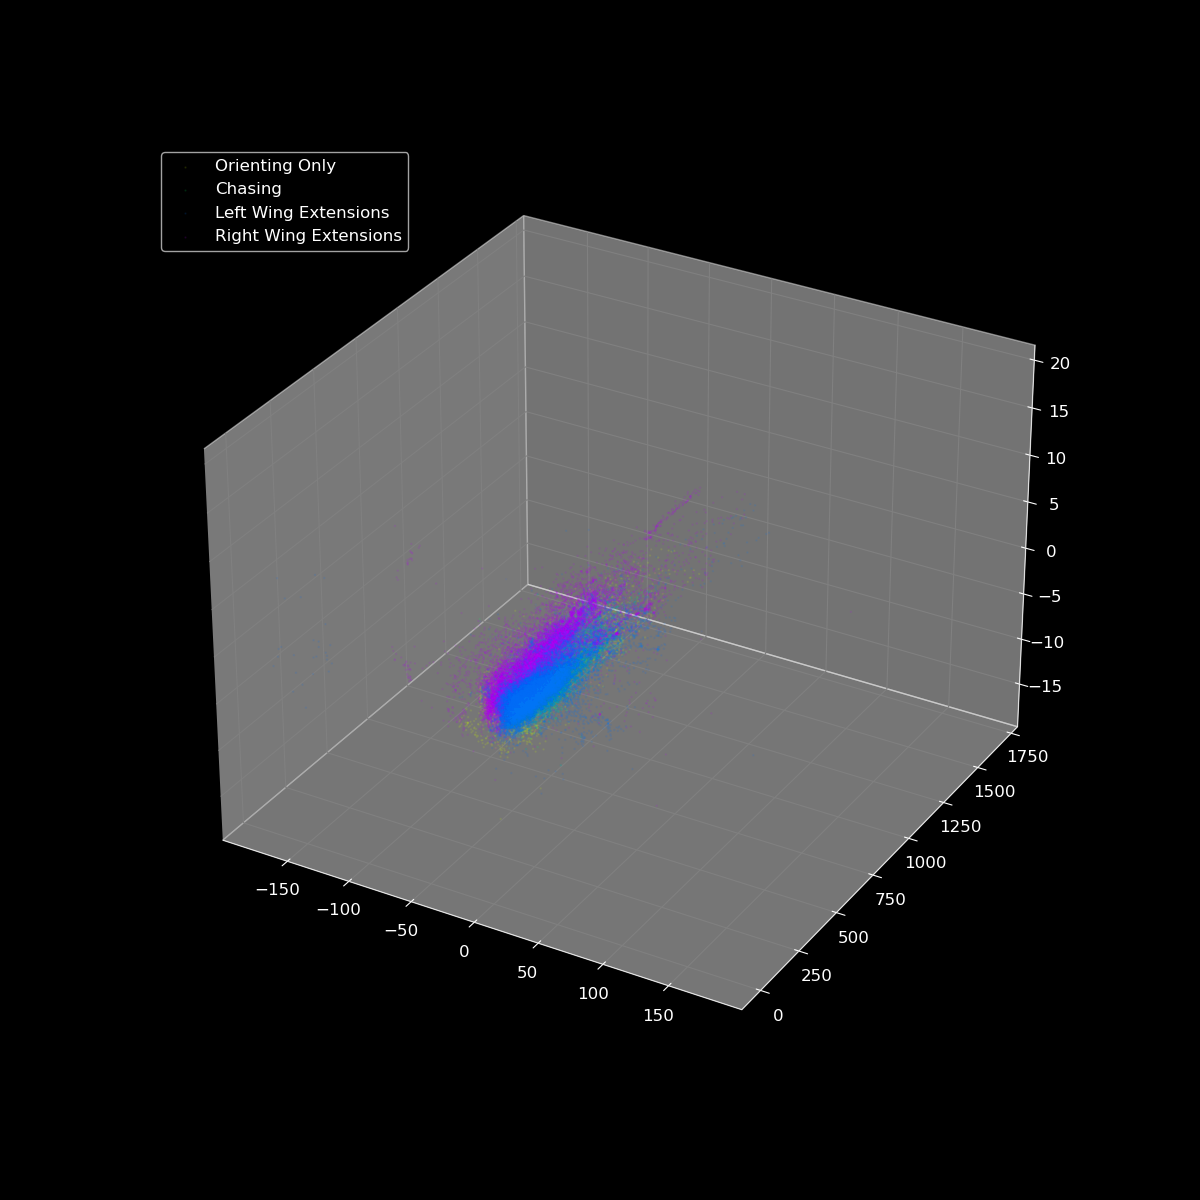

In [66]:
#fig, axn = pl.subplots(1, len(behavs2plot), figsize=(12,4), subplot_kw={'projection': '3d'})
fig, ax = pl.subplots(1, 1, figsize=(12,12), subplot_kw={'projection': '3d'})

y = 'Angular Area'
x = 'Angular Position'
z = 'Metric Relative Velocity' #'Angular Velocity'


for ai, (col, behav) in enumerate(zip(colors, behavs2plot)):
    #ax=axn[ai]
    plotdf = beh_[beh_[behav]==1]
    ax.scatter(plotdf[x], plotdf[y], plotdf[z], color=col, alpha=0.1, s=0.5, label=behav)
    # sns.scatterplot(data=plotdf, y=y, x=x, ax=ax, label=behav,
    #                 hue=z, palette='PuBuGn', size=z,  #hue_norm=(-10, 10),
    #                alpha=0.2, edgecolor='none')
    #ax.set_title(behav)
    ax.legend(bbox_to_anchor=(0, 1), loc='upper left')

<IPython.core.display.Javascript object>


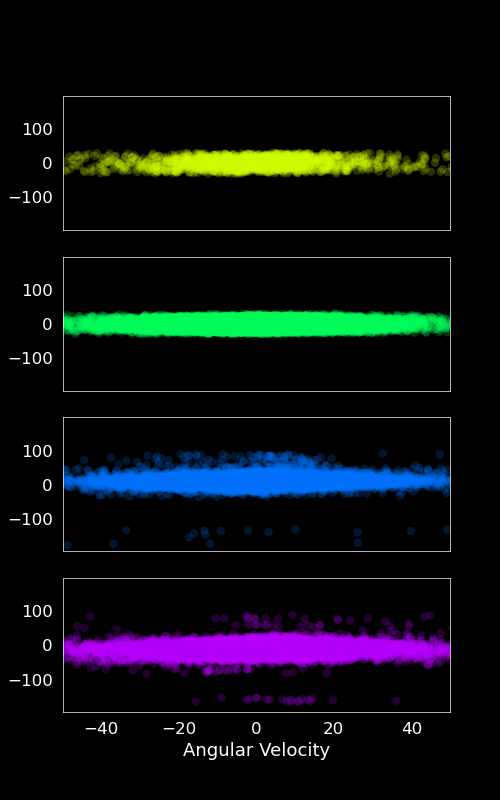

In [30]:

fig, axn = pl.subplots(len(behavs2plot), 1, figsize=(5,8), sharex=True, sharey=True)
x = 'Angular Velocity' #'Metric Relative Velocity'
y = 'Angular Position' #'Angular Area' 
ai = 0
for col, behav in zip(colors, behavs2plot):
    ax=axn[ai]
    plotdf = beh_[beh_[behav]==1]
    sns.scatterplot(data=plotdf, y=y, x=x, color=col, ax=ax, label=behav,
                   alpha=0.2, edgecolor='none')
    ax.legend_.remove()
    ax.set_xlim([-50, 50])
    ai+=1

<IPython.core.display.Javascript object>


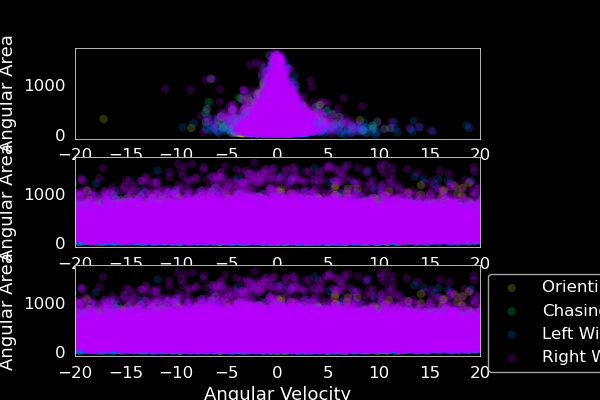

In [49]:
fig, axn = pl.subplots(3, 1)
behavs2plot = ['Orienting Only', 'Chasing', 'Left Wing Extensions', 'Right Wing Extensions']
colors = sns.color_palette('hsv', n_colors=len(behavs2plot))

ax=axn[0]
x = 'Metric Relative Velocity'
y = 'Angular Area' 
for col, behav in zip(colors, behavs2plot):
    plotdf = beh_[beh_[behav]==1]
    sns.scatterplot(data=plotdf, y=y, x=x, color=col, ax=ax, label=behav,
                   alpha=0.2, edgecolor='none')
    ax.legend_.remove()
    

ax=axn[1]
x = 'Angular Velocity'
y = 'Angular Area'
for col, behav in zip(colors, behavs2plot):
    plotdf = beh_[beh_[behav]==1]
    sns.scatterplot(data=plotdf, y=y, x=x, color=col, ax=ax, label=behav,
                   alpha=0.2, edgecolor='none')
    ax.legend_.remove()


ax=axn[2]
x = 'Angular Velocity'
y = 'Angular Area'
for col, behav in zip(colors, behavs2plot):
    plotdf = beh_[beh_[behav]==1]
    sns.scatterplot(data=plotdf, y=y, x=x, color=col, ax=ax, label=behav,
                   alpha=0.2, edgecolor='none')
    sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1,1))

for ax in axn.flat:
    #ax.set_box_aspect(1)
    ax.set_xlim([-20, 20])
pl.subplots_adjust(right=0.8)
